# Assignment 1 : Thompson Sampling for Multi-armed Bandit

###### Due date : 22/01/2018

###### By : Julien Roy and David Kanaa

### Section 1 : Summary of Thompson Sampling

Thompson Sampling is an approach that aims to balance the exploration and exploitation dilemma in RL or decision-making problems. It is particularly useful in online decision problems and can be applied to a wide variety of problem settings. It achieves better results than simpler algorithm such as $\epsilon$-greedy by allocating its exploration effort intelligently, based on the uncertainty around each action's value estimation, instead of wasting time by simply exploring every action with the same probability.

The process is simple. The agent uses a prior based on which the reward of each action is distributed. At each timestep, instead of greedily choosing the action that maximizes the expected reward based on the previous sequence, it greedily chooses an action according to a set of *sampled* action-values. It then simply execute the chosen action, collects the reward, and updates its model for that action. As time passes, its estimated reward distributions over each action become more and more accurate, and their variance diminish, according it to stabilize its behavior by choosing the optimal action every timestep.

**Thompson Sampling Algorithm** (taken from [1])

**for** t = 1,2,... **do**
1. Sample $\hat{\theta}$ ~ $p$ (where $p$ is our model's distribution)
2. Choose action $x_t$ that maximizes the expected reward given $x_t$, according to $\hat{\theta}$
3. Apply $x_t$ and observe $y_t$
4. Update the distribution $p$


The strengh of Thompson sampling lies in the fact that the exploration is driven by the amount of uncertainty over each action. An action that has been chosen many times but hasn't the best estimated expectation will be written off, but an action that has a low average reward but has only been selected a few times will still have high variance and therefore should produce, from time to time, a higher sample that will allow it to be explored further.

As mentioned earlier, Thompson Sampling is well suited for online decision problems requiring exploration. However, it doesn't perform well on sequential or highly non-stationary problems, or on more sophisticated problems in which some action's result are informative regarding which action should be performed next.



[1] : Russo, D., Van Roy, B., Kazerouni, A., & Osband, I. (2017). A Tutorial on Thompson Sampling. arXiv preprint arXiv:1707.02038.

### Section 2 : Implementation

This section simply contains our implementation of the 3 different algorithms, the bandit problem and evaluation pipeline that allows to compare those algorithms (basically most of our code).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
% matplotlib inline

###### Example of 10-arms Bandit with arms' mean normally distributed

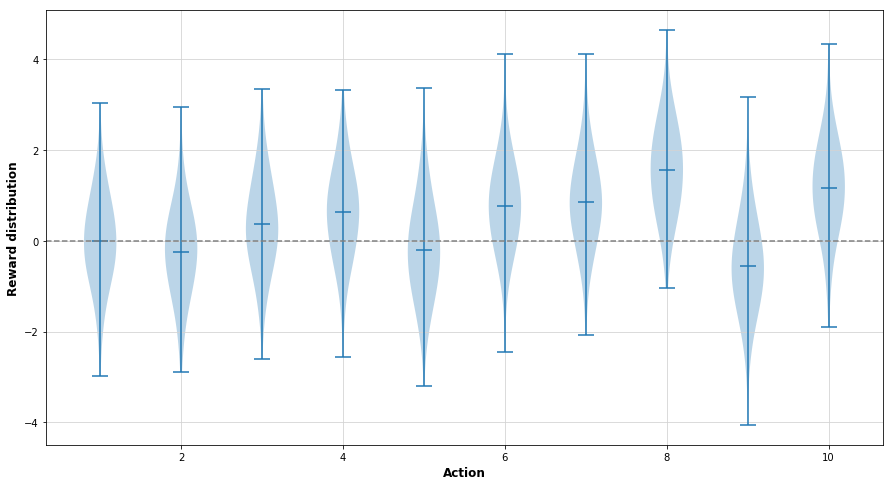

In [2]:
fs = 12  # fontsize
pos = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
means = np.random.normal(0., 1., size=(10,))
data = [np.random.normal(m, 1., size=1000) for m in means]

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))

axes.violinplot(data, pos, points=200, widths=0.4, showmeans=True,
                showextrema=True, showmedians=False, bw_method=0.5)
axes.axhline(y=0., color='grey', linestyle='--')
axes.set_xlabel("Action", fontweight='bold', fontsize=fs)
axes.set_ylabel("Reward distribution", fontweight='bold', fontsize=fs)
axes.grid(True, color="lightgrey")
plt.show()

###### Problem setups

In [3]:
class BanditMachine(object):
    
    def __init__(self, reward_distrib_family, arms_mean, arms_var, k=10):
        self.means = np.random.normal(arms_mean, arms_var, size=(k,))
        self.reward_distrib_family = reward_distrib_family
    
    def press_arm(self, arm_id):
        if self.reward_distrib_family == 'normal':
            return np.random.normal(self.means[arm_id], 1.)
        
        elif  self.reward_distrib_family == 'uniform':
            return np.random.uniform(self.means[arm_id]-3., self.means[arm_id]+3.)

###### Algorithms

In [4]:
def e_greedy_algorithm(e, bandit, max_steps, k):
    
    reward_log = []
    action_log = []
    regret_log = []
    optimal_action = np.argmax(bandit.means)
    
    # Initializes Q_t(a) and N(a)
    action_values = np.zeros(shape=(k,), dtype=np.float) # estimates of the real action values, which are the bandit.means
    action_freq = np.zeros(shape=(k,), dtype=np.int)

    for t in range(1, max_steps+1):

        # Action selection (epsilon-greedy)
        greed = np.random.uniform()
        if greed < e:
            a_t = np.random.randint(low=0, high=k)
        else:
            a_t = np.argmax(action_values)
        
        # Plays the bandit machine and get the reward
        R_t = bandit.press_arm(a_t)

        # Updates the action value
        action_freq[a_t] += 1
        action_values[a_t] = action_values[a_t] + (1 / action_freq[a_t]) * (R_t - action_values[a_t])
        
        reward_log.append(R_t)
        action_log.append(a_t)
        regret_log.append(bandit.means[optimal_action] - R_t)
    
    optimal_action_log = (np.array(action_log) == optimal_action)
    return reward_log, optimal_action_log, regret_log

In [5]:
def UCB_algorithm(c, bandit, max_steps, k):
    
    reward_log = []
    action_log = []
    regret_log = []
    optimal_action = np.argmax(bandit.means)
    
    # Initializes Q_t(a) and N(a)
    action_values = np.zeros(shape=(k,), dtype=np.float) # estimates of the real action values, which are the bandit.means
    action_freq = np.ones(shape=(k,), dtype=np.int)

    for t in range(1, max_steps+1):
        
        # Action selection (UCB)
        a_t = np.argmax(action_values + c * np.sqrt(np.log(t) / action_freq))
    
        # Plays the bandit machine and get the reward
        R_t = bandit.press_arm(a_t)

        # Updates the action value
        action_freq[a_t] += 1
        action_values[a_t] = action_values[a_t] + (1 / action_freq[a_t]) * (R_t - action_values[a_t])

        reward_log.append(R_t)
        action_log.append(a_t)
        regret_log.append(bandit.means[optimal_action] - R_t)
        
    optimal_action_log = (np.array(action_log) == optimal_action)
    return reward_log, optimal_action_log, regret_log

In [6]:
def Thompson_Sampling_algorithm(sigma, bandit, max_steps, k):
    
    reward_log = []
    action_log = []
    regret_log = []
    optimal_action = np.argmax(bandit.means)
    
    # initialise [prior] distribution parameters
    mu      = np.zeros(10)
    sigma2  = np.ones(10) * 1000
    
    for t in range(max_steps):
        
        # sample [model] from [prior] distribution
        params = np.random.normal(loc=mu, scale=np.sqrt(sigma2))

        # select & apply action, observe the reward
        action = np.random.choice(np.where(params == params.max())[0])  #np.argmax(params)
        reward = bandit.press_arm(action)
        
        # update [posterior] distribution
        sigma2_tmp      = 1. / ( (1./sigma2[action]) + (1./(sigma)) )
        mu[action]      = sigma2_tmp * ( (mu[action]/sigma2[action]) + (reward/(sigma)) )
        sigma2[action]  = sigma2_tmp
        
        
        reward_log.append(reward)
        action_log.append(action)
        regret_log.append(bandit.means[optimal_action] - reward)
    
    optimal_action_log = (np.array(action_log) == optimal_action)
    return reward_log, optimal_action_log, regret_log

###### Hyper-parameter search

In [7]:
def hyperparameter_search(runs, max_steps=1000, n_machines=2000, reward_distrib='normal', arms_mean=0., arms_var=1., k=10):
    """
        runs : a list of tuples as (algo, [hyperparams], name)
    """
    plt.figure(figsize=(20, 6))
    best_runs = {}
    
    for j, run in enumerate(runs):

        algo = runs[j][0]
        hyperparams = runs[j][1]
        name = runs[j][2]
        
        avg_regret_per_step = []
        print("Processing {2} different runs for algo {0} : {1}".format(j+1, name, len(hyperparams)))
        for param in tqdm(hyperparams):
            
            master_reward_log = np.zeros(shape=(n_machines, max_steps), dtype=np.float)
            master_action_log = np.zeros(shape=(n_machines, max_steps), dtype=np.bool)
            master_regret_log = np.zeros(shape=(n_machines, max_steps), dtype=np.float)

            for i in range(n_machines):
                bandit = BanditMachine(reward_distrib, arms_mean, arms_var, k)
                reward_log, optimal_action_log, regret_log = algo(param, bandit, max_steps, k)

                master_reward_log[i, :] = reward_log
                master_action_log[i, :] = optimal_action_log
                master_regret_log[i, :] = regret_log

            avg_reward_log = np.mean(master_reward_log, axis=0)
            avg_action_log = np.mean(master_action_log, axis=0) * 100.
            avg_regret_log = np.mean(master_regret_log, axis=0)
            avg_regret_per_step.append(np.mean(avg_regret_log))
            
            if avg_regret_per_step[-1] == min(avg_regret_per_step):
                
                best_runs[name] = (avg_action_log, avg_regret_log, param)
                

        plt.semilogx(hyperparams, avg_regret_per_step, label=name)
        plt.xlabel("Parameter values", fontweight='bold')
        plt.ylabel("Average Regret per step", fontweight='bold')
        plt.legend(loc='best')

    plt.show()
    
    return best_runs


def plot_best_results(best_runs):
    
    plt.figure(figsize=(20, 6))
    for name in best_runs.keys():

        avg_action_log = best_runs[name][0]
        avg_regret_log = best_runs[name][1]

        if name == 'UCB':
            run_label = 'UCB : c={0}'.format(best_runs[name][2])

        elif name == 'e-greedy':
            run_label = 'e-greedy : e={0}'.format(best_runs[name][2])
        
        elif name == 'TS':
            run_label = 'TS : sigma={0}'.format(best_runs[name][2])

        else:
            raise ValueError('Unrecognized algorithm.')

        plt.subplot(1,2,1)
        plt.plot(range(avg_action_log.shape[0]), avg_action_log, label=run_label)
        plt.xlabel("Steps", fontweight='bold')
        plt.ylabel("Optimal action (%)", fontweight='bold')
        plt.legend(loc='best')

        plt.subplot(1,2,2)
        plt.plot(range(avg_regret_log.shape[0]), avg_regret_log, label=run_label)
        plt.xlabel("Steps", fontweight='bold')
        plt.ylabel("Average Regret", fontweight='bold')
        plt.legend(loc='best')

    plt.show()

### Section 3 : Experiments

In this section, we compare the three algorithms (e-greedy, UCB and Thompson Sampling) on 4 different Bandit environments. 

For each Bandit environment, and for each algorithm, we run a simple 1-dimensionnal hyperparameter search. That allows to fairly compare the algorithms. The hyperparameters being picked by this search for e-greedy, UCB and TS algorithms are respectively the epsilon-parameter, which controls the percentage of time the agent will pick a random action, the c-parameter, which also allows to control the amount of exploration and finally the variance of the arm's true values according to the agent's prior. The results of that search are presented on the widest graph, and the best configuration is picked according to the lowest average empirical regret per step. That makes a total of 6 experiments per algorithm, and the best configuration of each one are further compared on the two smaller graphs of average empirical regret and optimal action ratio. 

For each experiment, we run the algorithm for 1000 timesteps and we average the performance on the algorithm over 2000 sampled bandit machines. Finally, as we mentionned, this whole process is repeated in 4 different bandit environments which vary different parameters of the problem : the variance of the arm's real values, the reward distribution family and the number of arms per bandit.

###### Bandit environment 1 : 
* Reward distribution family : Gaussian
* Number of arms : 10

Processing 6 different runs for algo 1 : e-greedy


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:21<00:00, 13.54s/it]


Processing 6 different runs for algo 2 : UCB


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:13<00:00, 22.32s/it]


Processing 6 different runs for algo 3 : TS


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [04:35<00:00, 45.86s/it]


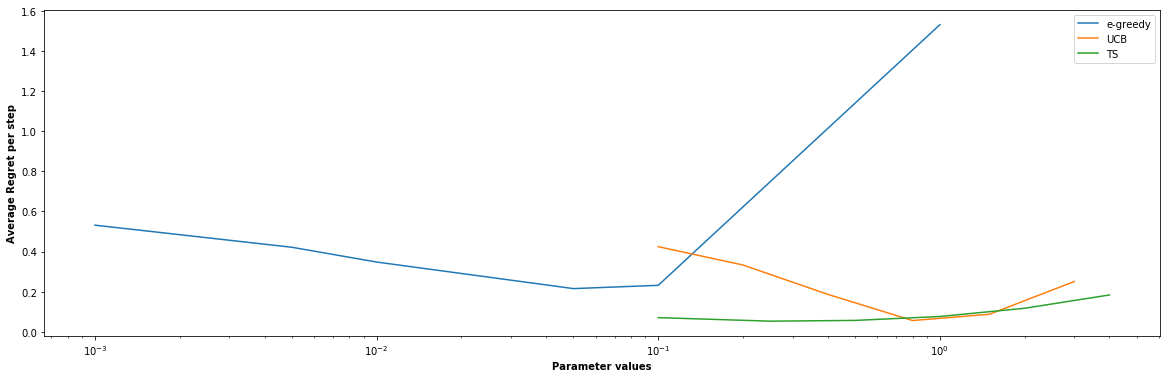

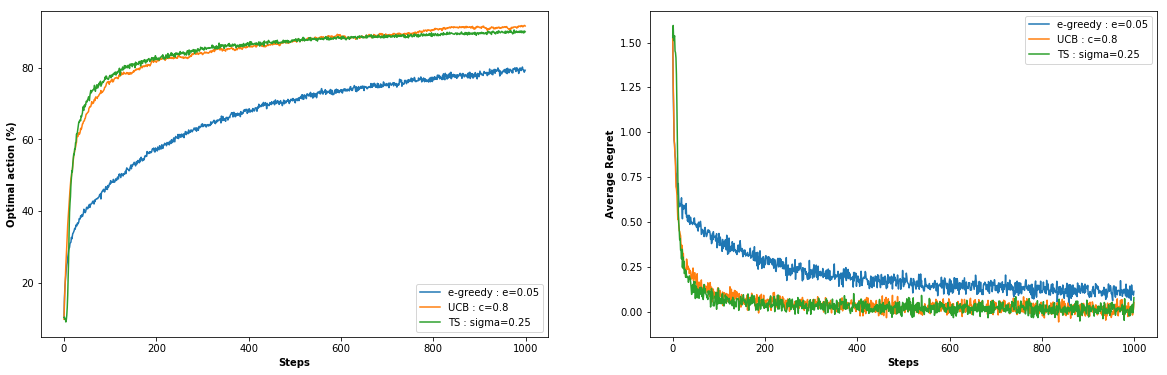

In [8]:
e_values = [0.001, 0.005, 0.01, 0.05, 0.1, 1.] # epsilon for e-greedy
c_values = [0.1, 0.2, 0.4, 0.8, 1.5, 3.]       # c parameter that controls exploration
s_values = [0.1, 0.25, 0.5, 1., 2., 4. ]       # sigma values for arms distributions

best_runs = hyperparameter_search(runs=[(e_greedy_algorithm, e_values, 'e-greedy'), 
                                        (UCB_algorithm, c_values, 'UCB'),
                                        (Thompson_Sampling_algorithm, s_values, 'TS')
                                       ],
                                  max_steps=1000,
                                  n_machines=2000,
                                  reward_distrib='normal', 
                                  arms_mean=0., 
                                  arms_var=1., 
                                  k=10)

plot_best_results(best_runs)

###### Bandit environment 2 : 
* Reward distribution family : Gaussian (but each arm's distribution mean are even less spaced out)
* Number of arms : 10

Processing 6 different runs for algo 1 : e-greedy


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:22<00:00, 13.80s/it]


Processing 6 different runs for algo 2 : UCB


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:13<00:00, 22.24s/it]


Processing 6 different runs for algo 3 : TS


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [04:33<00:00, 45.66s/it]


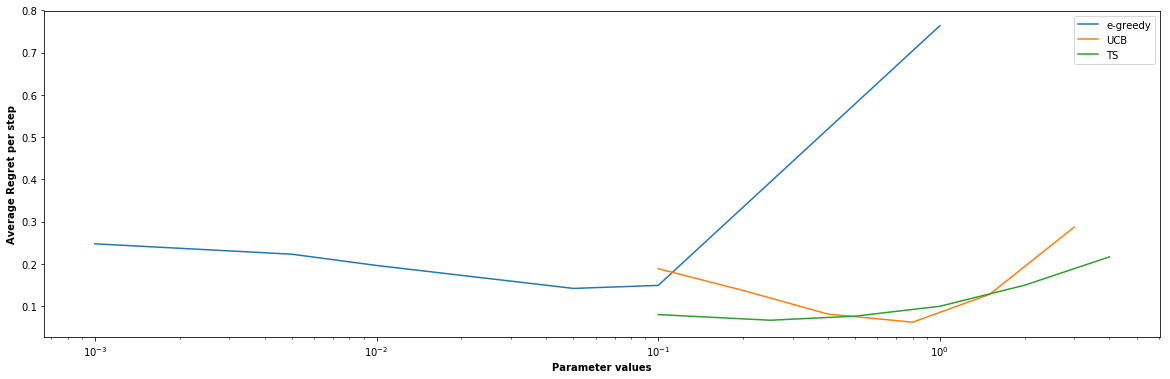

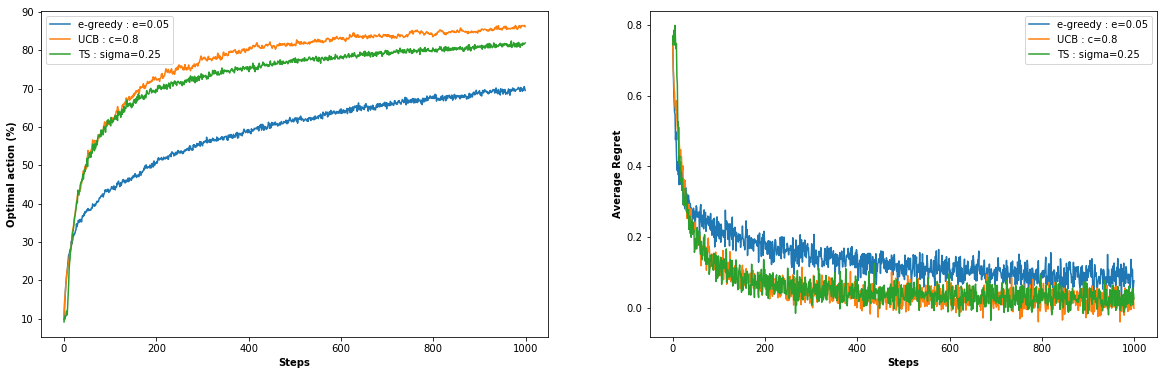

In [8]:
e_values = [0.001, 0.005, 0.01, 0.05, 0.1, 1.] # epsilon for e-greedy
c_values = [0.1, 0.2, 0.4, 0.8, 1.5, 3.]       # c parameter that controls exploration
s_values = [0.1, 0.25, 0.5, 1., 2., 4. ]       # sigma values for arms distributions

best_runs = hyperparameter_search(runs=[(e_greedy_algorithm, e_values, 'e-greedy'), 
                                        (UCB_algorithm, c_values, 'UCB'),
                                        (Thompson_Sampling_algorithm, s_values, 'TS')
                                       ],
                                  max_steps=1000,
                                  n_machines=2000,
                                  reward_distrib='normal', 
                                  arms_mean=0., 
                                  arms_var=0.5, 
                                  k=10)

plot_best_results(best_runs)

###### Bandit environment 3 : 
* Reward distribution family : Uniform
* Number of arms : 25

Processing 6 different runs for algo 1 : e-greedy


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:12<00:00, 12.01s/it]


Processing 6 different runs for algo 2 : UCB


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:11<00:00, 21.86s/it]


Processing 6 different runs for algo 3 : TS


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [04:29<00:00, 44.90s/it]


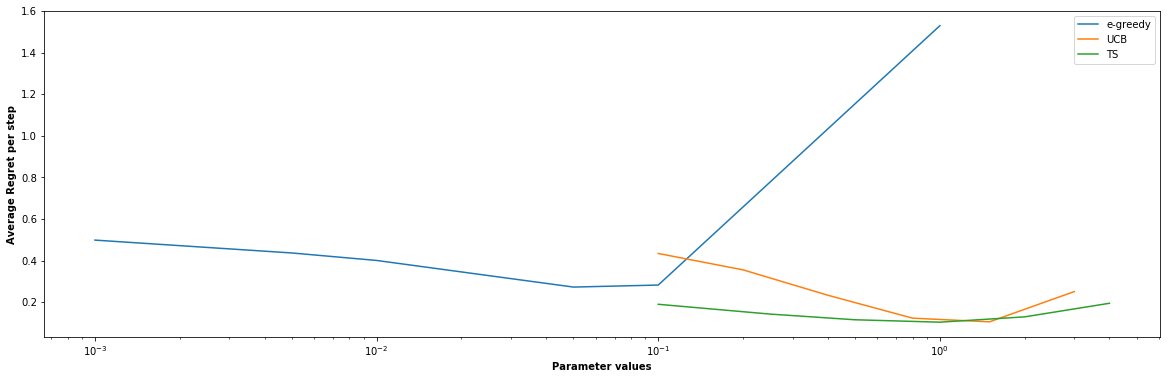

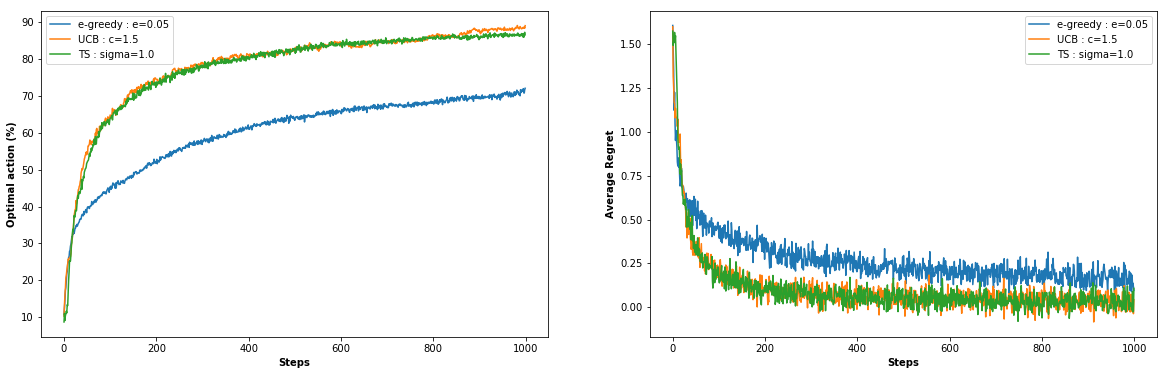

In [9]:
e_values = [0.001, 0.005, 0.01, 0.05, 0.1, 1.] # epsilon for e-greedy
c_values = [0.1, 0.2, 0.4, 0.8, 1.5, 3.]       # c parameter that controls exploration
s_values = [0.1, 0.25, 0.5, 1., 2., 4. ]       # sigma values for arms distributions

best_runs = hyperparameter_search(runs=[(e_greedy_algorithm, e_values, 'e-greedy'), 
                                        (UCB_algorithm, c_values, 'UCB'),
                                        (Thompson_Sampling_algorithm, s_values, 'TS')
                                       ],
                                  max_steps=1000,
                                  n_machines=2000,
                                  reward_distrib='uniform', 
                                  arms_mean=0., 
                                  arms_var=1., 
                                  k=10)

plot_best_results(best_runs)

###### Bandit environment 4 : 
* Reward distribution family : Gaussian
* Number of arms : 25

Processing 6 different runs for algo 1 : e-greedy


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:22<00:00, 13.83s/it]


Processing 6 different runs for algo 2 : UCB


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:17<00:00, 22.97s/it]


Processing 6 different runs for algo 3 : TS


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [04:39<00:00, 46.60s/it]


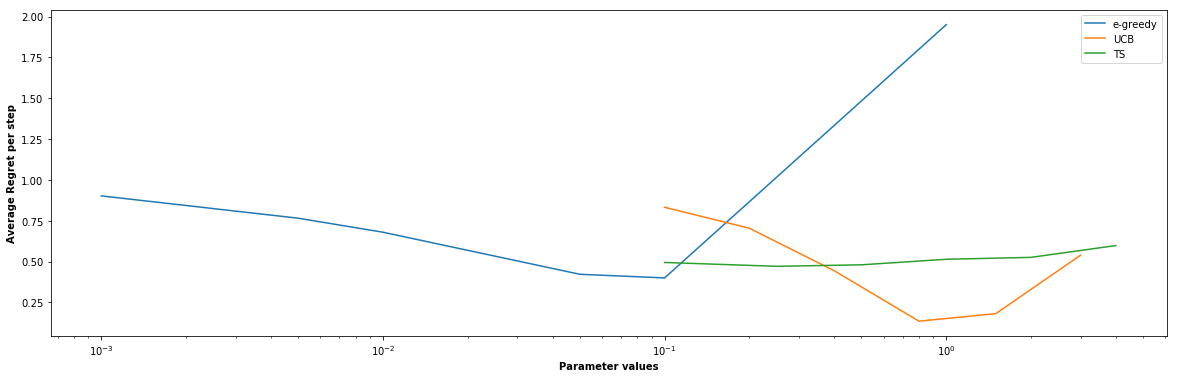

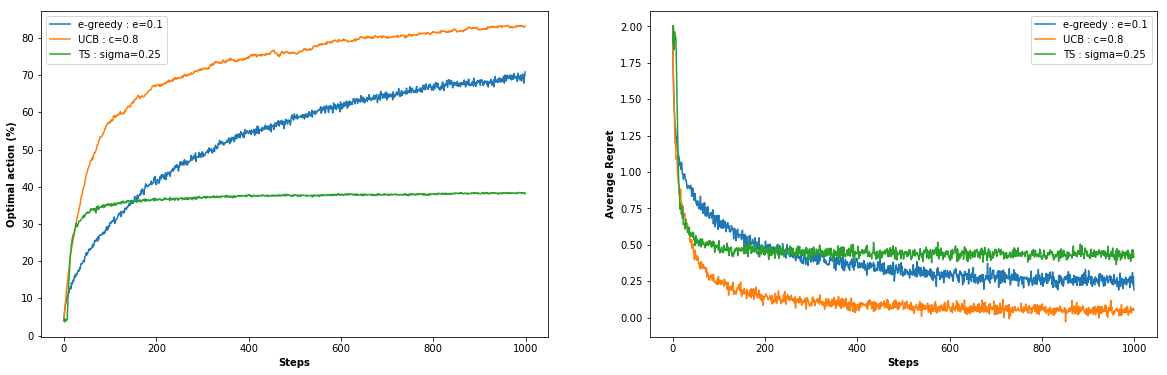

In [11]:
e_values = [0.001, 0.005, 0.01, 0.05, 0.1, 1.] # epsilon for e-greedy
c_values = [0.1, 0.2, 0.4, 0.8, 1.5, 3.]       # c parameter that controls exploration
s_values = [0.1, 0.25, 0.5, 1., 2., 4. ]       # sigma values for arms distributions

best_runs = hyperparameter_search(runs=[(e_greedy_algorithm, e_values, 'e-greedy'), 
                                        (UCB_algorithm, c_values, 'UCB'),
                                        (Thompson_Sampling_algorithm, s_values, 'TS')
                                       ],
                                  max_steps=1000,
                                  n_machines=2000,
                                  reward_distrib='normal', 
                                  arms_mean=0., 
                                  arms_var=1., 
                                  k=25)

plot_best_results(best_runs)

### Conclusion

Our first three experiments seem to show that both Thompson Sampling (TS) and Upper Confidence Bound (UCB) algorithms perform much better than a simple epsilon-greedy approach to the k-armed Bandit problem. In bandit environments 1 and 3, UCB and TS were almost equivalent on both performance metric (regret and optimal action ratio), but on bandit environment 2, for which the arm's true values were even closer, UCB chooses the optimal action more often than TS. Finally, in the last bandit environment, for which there were 25 arms per bandit machine, the UCB algorithm vastly outperform Thompson Sampling. In fact, even e-greedy is doing a lot better than TS for that problem setting. That might be a sign that Thompson Sampling struggles to adapt its model of the environment in the case of a large number of possible actions. Evidently, a lot more experimentation would be necessary to properly defend such a statement. 

Nevertheless, we have successfully implemented a pretty flexible pipeline in which we can compare different algorithms on various bandit problem settings, and implemented and compared 3 popular algorithms with it. We conclude that both UCB and Thompson Sampling seem more efficient at finding the optimal policy than e-greedy (although our final experiment seem to uncover a potential downside of Thompson Sampling). For its simplicity and robustness, we would consider that UCB is the best performing of those algorithms for the k-armed Bandit problem. It would be interesting to further test these algorithms in more challenging conditions like in the associative case (contextual bandit) or for the nonstationnary case.